ali535_ACO

C:\Users\ButterflyMX\AppData\Local\Temp\ipykernel_24152\2267092015.py:26: RuntimeWarning: divide by zero encountered in divide
  ((1 / np.linalg.norm(self.points - self.points[ant], axis=1)) ** self.beta)
C:\Users\ButterflyMX\AppData\Local\Temp\ipykernel_24152\2267092015.py:71: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(np.linalg.norm(self.points[self.tour[i]] - self.points[self.tour[i + 1]]) for i in range(self.n - 1))


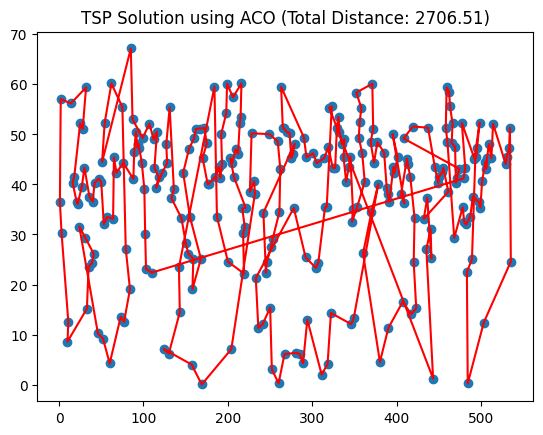

Time taken to render: 387.66612482070923 seconds




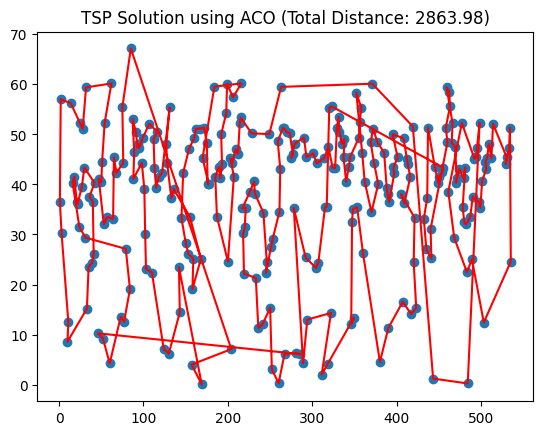

Time taken to render: 478.62582659721375 seconds


Average Tour Length: 2785.2449882938054
Average Time taken to render: 433.1459757089615 seconds


In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
import time

class AntColony:
    def __init__(self, points, num_ants=10, alpha=1, beta=3, evaporation_rate=0.5):
        self.points = np.array(points)
        self.n = len(points)
        self.num_ants = num_ants
        self.alpha = alpha
        self.beta = beta
        self.evaporation_rate = evaporation_rate
        self.pheromone = np.ones((self.n, self.n))  # Initialize pheromone matrix

    def _update_pheromone(self, tours):
        # Evaporate pheromone
        self.pheromone *= (1 - self.evaporation_rate)
        # Update pheromone on each edge
        for tour in tours:
            for i in range(self.n):
                self.pheromone[tour[i], tour[(i + 1) % self.n]] += 1 / self.total_distance(tour)

    def _select_next_city(self, ant, visited):
        probabilities = (self.pheromone[ant, :] ** self.alpha) * \
                        ((1 / np.linalg.norm(self.points - self.points[ant], axis=1)) ** self.beta)
        probabilities[list(visited)] = 0  # Do not select visited cities
        probabilities /= probabilities.sum()  # Normalize probabilities
        return np.random.choice(np.arange(self.n), p=probabilities)

    def total_distance(self, tour):
        return sum(np.linalg.norm(self.points[tour[i]] - self.points[tour[i + 1]]) for i in range(self.n - 1))

    def solve(self, max_iter=100):
        best_tour = None
        best_distance = float('inf')
        for _ in range(max_iter):
            tours = []
            for _ in range(self.num_ants):
                ant = np.random.randint(0, self.n)
                visited = {ant}
                tour = [ant]
                for _ in range(self.n - 1):
                    next_city = self._select_next_city(ant, visited)
                    tour.append(next_city)
                    visited.add(next_city)
                    ant = next_city
                tours.append(tour)
            self._update_pheromone(tours)
            # Find the best tour in this iteration
            for tour in tours:
                distance = self.total_distance(tour)
                if distance < best_distance:
                    best_distance = distance
                    best_tour = tour
        return best_tour

class TSPSolver:
    def __init__(self, points):
        self.points = np.array(points)
        self.n = len(points)
        self.tour = None

    def solve(self):
        aco = AntColony(self.points)
        self.tour = aco.solve()
        # Connect the last city back to the starting city to form a closed tour
        self.tour.append(self.tour[0])

    def total_distance(self):
        return np.sum(np.linalg.norm(self.points[self.tour[i]] - self.points[self.tour[i + 1]]) for i in range(self.n - 1))

# Parse the TSP dataset and extract coordinates
def parse_tsp_dataset(data):
    coordinates = []
    pattern = re.compile(r'\s*(\d+)\s+(\d+\.\d+)\s+(\d+\.\d+)')

    in_node_coord_section = False
    for line in data.split('\n'):
        if line.startswith("NODE_COORD_SECTION"):
            in_node_coord_section = True
            continue
        if line.startswith("EOF"):
            break
        if in_node_coord_section:
            match = pattern.match(line)
            if match:
                coordinates.append((float(match.group(1)), float(match.group(2))))

    return coordinates

# Load the TSP dataset from a file
def load_tsp_file(file_path):
    with open(file_path, 'r') as file:
        tsp_data = file.read()
    return tsp_data

# Specify the path to your TSP file
tsp_file_path = "ali535.tsp"

# Load the TSP dataset from the file
tsp_data = load_tsp_file(tsp_file_path)

# Parse the dataset and extract coordinates
city_coordinates = parse_tsp_dataset(tsp_data)

# Create TSPSolver instance and solve using ant colony optimization
total_distances = []
render_times = []

for i in range(2):
    start_time = time.time()  # Start timing for this run
    solver = TSPSolver(city_coordinates)
    solver.solve()
    total_distance = solver.total_distance()
    total_distances.append(total_distance)
    # Plot the solution
    plt.figure()
    plt.scatter(solver.points[:, 0], solver.points[:, 1])
    tour_points = np.array([solver.points[i] for i in solver.tour])
    plt.plot(tour_points[:, 0], tour_points[:, 1], 'r-')
    plt.title(f'TSP Solution using ACO (Total Distance: {total_distance:.2f})')
    plt.show()

    end_time = time.time()  # End timing for this run
    rendered_time = end_time - start_time  # Calculate render time for this run
    render_times.append(rendered_time)
    print("Time taken to render:", rendered_time, "seconds\n\n")

# Calculate and print average tour length and average time taken to render
average_tour_length = np.mean(total_distances)
average_render_time = np.mean(render_times)
print("Average Tour Length:", average_tour_length)
print("Average Time taken to render:", average_render_time, "seconds")


ali535_SA

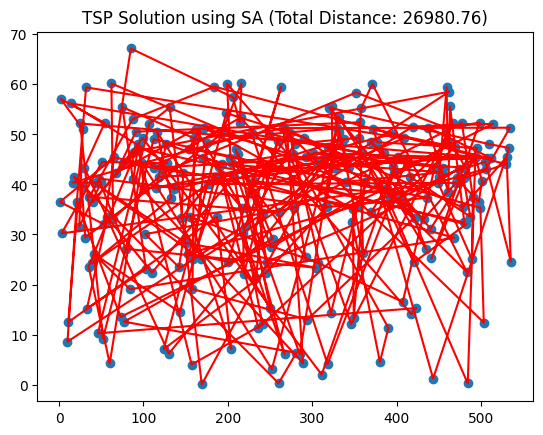

Time taken to render: 1.4126737117767334 seconds




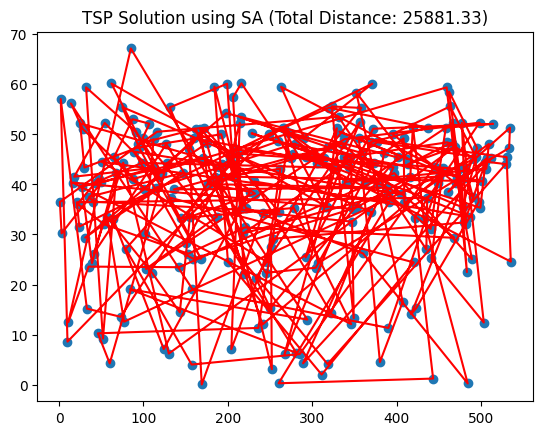

Time taken to render: 1.5850286483764648 seconds




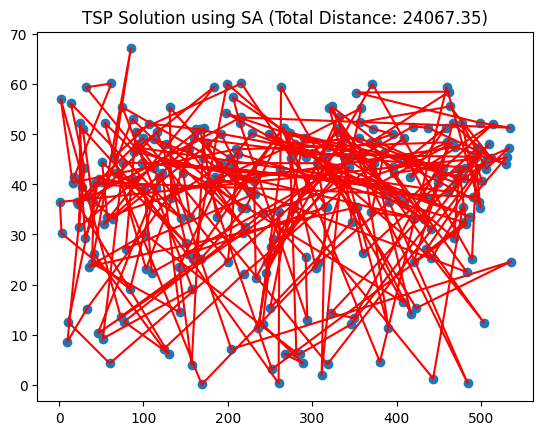

Time taken to render: 1.4922850131988525 seconds


Average Tour Length: 25643.149338964966
Average Time taken to render: 1.4966624577840169 seconds


In [2]:
import re
import numpy as np
import matplotlib.pyplot as plt
import time
import math

class TSPSolver:
    def __init__(self, points):
        self.points = np.array(points)
        self.n = len(points)
        self.tour = None

    def initial_solution(self):
        return np.random.permutation(self.n)

    def acceptance_probability(self, old_cost, new_cost, temperature):
        if new_cost < old_cost:
            return 1.0
        return math.exp((old_cost - new_cost) / temperature)

    def simulated_annealing(self, initial_temperature=1000, cooling_rate=0.99, stopping_temperature=0.1):
        current_solution = self.initial_solution()
        current_cost = self.total_distance(current_solution)

        temperature = initial_temperature

        while temperature > stopping_temperature:
            new_solution = np.copy(current_solution)
            i, j = np.random.choice(self.n, size=2, replace=False)
            new_solution[i], new_solution[j] = new_solution[j], new_solution[i]
            new_cost = self.total_distance(new_solution)

            if self.acceptance_probability(current_cost, new_cost, temperature) > np.random.rand():
                current_solution = new_solution
                current_cost = new_cost

            temperature *= cooling_rate

        self.tour = current_solution.tolist()

    def total_distance(self, tour):
        return sum(np.linalg.norm(self.points[tour[i]] - self.points[tour[i + 1]]) for i in range(self.n - 1))

    def solve(self):
        self.simulated_annealing()
        # Connect the last city back to the starting city to form a closed tour
        self.tour.append(self.tour[0])

# Parse the TSP dataset and extract coordinates
def parse_tsp_dataset(data):
    coordinates = []
    pattern = re.compile(r'\s*(\d+)\s+(\d+\.\d+)\s+(\d+\.\d+)')

    in_node_coord_section = False
    for line in data.split('\n'):
        if line.startswith("NODE_COORD_SECTION"):
            in_node_coord_section = True
            continue
        if line.startswith("EOF"):
            break
        if in_node_coord_section:
            match = pattern.match(line)
            if match:
                coordinates.append((float(match.group(1)), float(match.group(2))))

    return coordinates

# Load the TSP dataset from a file
def load_tsp_file(file_path):
    with open(file_path, 'r') as file:
        tsp_data = file.read()
    return tsp_data

# Specify the path to your TSP file
tsp_file_path = "ali535.tsp"

# Load the TSP dataset from the file
tsp_data = load_tsp_file(tsp_file_path)

# Parse the dataset and extract coordinates
city_coordinates = parse_tsp_dataset(tsp_data)

# Create TSPSolver instance and solve using simulated annealing
total_distances = []
render_times = []

for i in range(3):
    start_time = time.time()  # Start timing for this run
    solver = TSPSolver(city_coordinates)
    solver.solve()
    total_distance = solver.total_distance(solver.tour)
    total_distances.append(total_distance)
    # Plot the solution
    plt.figure()
    plt.scatter(solver.points[:, 0], solver.points[:, 1])
    tour_points = np.array([solver.points[i] for i in solver.tour])
    plt.plot(tour_points[:, 0], tour_points[:, 1], 'r-')
    plt.title(f'TSP Solution using SA (Total Distance: {total_distance:.2f})')
    plt.show()

    end_time = time.time()  # End timing for this run
    rendered_time = end_time - start_time  # Calculate render time for this run
    render_times.append(rendered_time)
    print("Time taken to render:", rendered_time, "seconds\n\n")

# Calculate and print average tour length and average time taken to render
average_tour_length = np.mean(total_distances)
average_render_time = np.mean(render_times)
print("Average Tour Length:", average_tour_length)
print("Average Time taken to render:", average_render_time, "seconds")


ali535_NIH

Iteration 546: Improved total distance to 2630.39
Iteration 4273: Improved total distance to 2626.58
Iteration 4546: Improved total distance to 2625.82
Iteration 4547: Improved total distance to 2616.93
Iteration 4820: Improved total distance to 2615.53
Iteration 11001: Improved total distance to 2613.72
Iteration 11275: Improved total distance to 2610.37
Iteration 13200: Improved total distance to 2608.77
Iteration 14851: Improved total distance to 2603.25
Iteration 17941: Improved total distance to 2603.23
Iteration 18215: Improved total distance to 2602.43
Iteration 18488: Improved total distance to 2591.24
Iteration 18976: Improved total distance to 2588.21
Iteration 25051: Improved total distance to 2586.25
Iteration 29425: Improved total distance to 2584.37
Iteration 34100: Improved total distance to 2577.40
Iteration 34375: Improved total distance to 2576.69
Iteration 40700: Improved total distance to 2574.04
Iteration 42626: Improved total distance to 2559.83
Iteration 42900: I

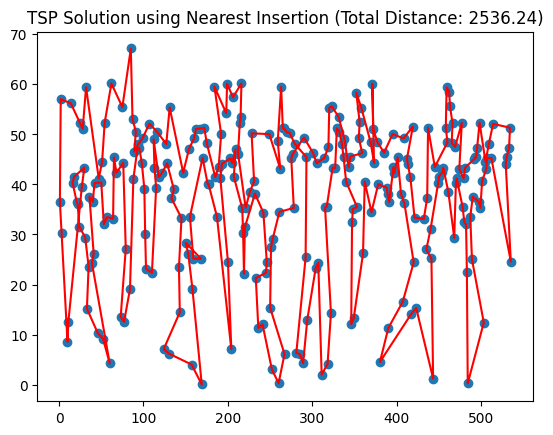

Time taken to render: 122.87163066864014 seconds


Iteration 2200: Improved total distance to 2635.04
Iteration 3850: Improved total distance to 2632.60
Iteration 9625: Improved total distance to 2631.00
Iteration 15823: Improved total distance to 2627.19
Iteration 16096: Improved total distance to 2626.43
Iteration 17601: Improved total distance to 2612.23
Iteration 19800: Improved total distance to 2609.57
Iteration 24541: Improved total distance to 2609.55
Iteration 24813: Improved total distance to 2608.80
Iteration 24814: Improved total distance to 2608.29
Iteration 26126: Improved total distance to 2606.34
Iteration 26172: Improved total distance to 2605.41
Iteration 26400: Improved total distance to 2597.52
Iteration 28351: Improved total distance to 2595.56
Iteration 31075: Improved total distance to 2593.68
Iteration 41251: Improved total distance to 2590.64
Iteration 42900: Improved total distance to 2588.23
Iteration 45376: Improved total distance to 2582.72
Iteration 46200:

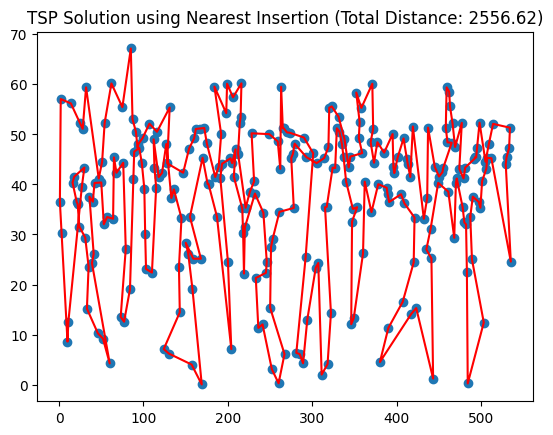

Time taken to render: 126.96681070327759 seconds


Iteration 1925: Improved total distance to 2633.78
Iteration 11550: Improved total distance to 2630.00
Iteration 12650: Improved total distance to 2625.91
Iteration 13750: Improved total distance to 2621.02
Iteration 15400: Improved total distance to 2618.72
Iteration 17260: Improved total distance to 2617.50
Iteration 17325: Improved total distance to 2615.86
Iteration 18701: Improved total distance to 2611.33
Iteration 20076: Improved total distance to 2604.52
Iteration 24898: Improved total distance to 2600.71
Iteration 25171: Improved total distance to 2599.95
Iteration 25172: Improved total distance to 2591.06
Iteration 25445: Improved total distance to 2589.66
Iteration 31626: Improved total distance to 2587.85
Iteration 31900: Improved total distance to 2584.50
Iteration 33825: Improved total distance to 2582.90
Iteration 35476: Improved total distance to 2577.38
Iteration 38566: Improved total distance to 2577.37
Iteration 3884

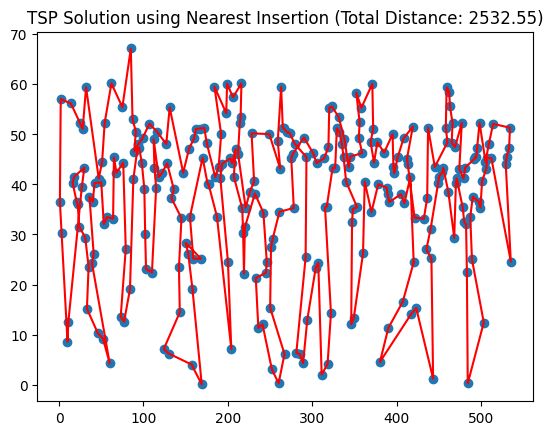

Time taken to render: 162.72569465637207 seconds


Average Tour Length: 2541.804377996521
Average Time taken to render: 137.5213786760966 seconds


In [3]:
import re
import numpy as np
import matplotlib.pyplot as plt
import time

class TSPSolver:
    def __init__(self, points):
        self.points = np.array(points)
        self.n = len(points)
        self.tour = None

    def nearest_insertion(self, start=None):
        if start is None:
            start = np.random.randint(0, self.n)
        unvisited = set(range(self.n))
        unvisited.remove(start)
        tour = [start]

        while unvisited:
            min_distance = float('inf')
            min_city = None
            for i in range(len(tour)):
                for j in unvisited:
                    dist = np.linalg.norm(self.points[tour[i]] - self.points[j]) + np.linalg.norm(self.points[j] - self.points[tour[(i + 1) % len(tour)]]) - np.linalg.norm(self.points[tour[i]] - self.points[tour[(i + 1) % len(tour)]])
                    if dist < min_distance:
                        min_distance = dist
                        min_city = j
                        position = i + 1
            tour.insert(position, min_city)
            unvisited.remove(min_city)

        self.tour = tour

    def total_distance(self, tour=None):
        if tour is None:
            tour = self.tour
        return sum(np.linalg.norm(self.points[tour[i]] - self.points[tour[i + 1]]) for i in range(self.n - 1))

    def solve(self):
        self.nearest_insertion()
        # Connect the last city back to the starting city to form a closed tour
        self.tour.append(self.tour[0])
        prev_distance = self.total_distance()

        for i in range(1, self.n - 1):
            for j in range(i + 1, self.n):
                self.tour[i], self.tour[j] = self.tour[j], self.tour[i]
                new_distance = self.total_distance()
                if new_distance < prev_distance:
                    print(f"Iteration {i * self.n + j - 1}: Improved total distance to {new_distance:.2f}")
                    prev_distance = new_distance
                else:
                    self.tour[i], self.tour[j] = self.tour[j], self.tour[i]  # Revert back if the swap doesn't improve the distance


# Parse the TSP dataset and extract coordinates
def parse_tsp_dataset(data):
    coordinates = []
    pattern = re.compile(r'\s*(\d+)\s+(\d+\.\d+)\s+(\d+\.\d+)')

    in_node_coord_section = False
    for line in data.split('\n'):
        if line.startswith("NODE_COORD_SECTION"):
            in_node_coord_section = True
            continue
        if line.startswith("EOF"):
            break
        if in_node_coord_section:
            match = pattern.match(line)
            if match:
                coordinates.append((float(match.group(1)), float(match.group(2))))

    return coordinates

# Load the TSP dataset from a file
def load_tsp_file(file_path):
    with open(file_path, 'r') as file:
        tsp_data = file.read()
    return tsp_data

# Specify the path to your TSP file
tsp_file_path = "ali535.tsp"

# Load the TSP dataset from the file
tsp_data = load_tsp_file(tsp_file_path)

# Parse the dataset and extract coordinates
city_coordinates = parse_tsp_dataset(tsp_data)

# Create TSPSolver instance and solve using nearest insertion
total_distances = []
render_times = []

for i in range(3):
    start_time = time.time()  # Start timing for this run
    solver = TSPSolver(city_coordinates)
    solver.solve()
    total_distance = solver.total_distance()
    total_distances.append(total_distance)
    # Plot the solution
    plt.figure()
    plt.scatter(solver.points[:, 0], solver.points[:, 1])
    tour_points = np.array([solver.points[i] for i in solver.tour])
    plt.plot(tour_points[:, 0], tour_points[:, 1], 'r-')
    plt.title(f'TSP Solution using Nearest Insertion (Total Distance: {total_distance:.2f})')
    plt.show()

    end_time = time.time()  # End timing for this run
    rendered_time = end_time - start_time  # Calculate render time for this run
    render_times.append(rendered_time)
    print("Time taken to render:", rendered_time, "seconds\n\n")

# Calculate and print average tour length and average time taken to render
average_tour_length = np.mean(total_distances)
average_render_time = np.mean(render_times)
print("Average Tour Length:", average_tour_length)
print("Average Time taken to render:", average_render_time, "seconds")